In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from LSTM_demo import LSTM
import torch
import torch.nn as nn

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Preprocessing

In [2]:
# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)
    
    close_prices = data['Close'].rename(ticker + "_close")
    
    df_close = pd.concat([df_close, close_prices], axis=1)

df_close.dropna(inplace=True)

In [3]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()
  
df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)
df_log_return['^GSPC_log_return'].tail()

2024-04-08 00:00:00    0.001444
2024-04-09 00:00:00   -0.009502
2024-04-10 00:00:00    0.007417
2024-04-11 00:00:00   -0.014658
2024-04-12 00:00:00         NaN
Name: ^GSPC_log_return, dtype: float64

In [15]:
df_log_return

,^GSPC_log_return,AAPL_log_return,MSFT_log_return,AMZN_log_return,NVDA_log_return,GOOGL_log_return,TSLA_log_return,META_log_return
2012-05-18 00:00:00,0.015909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00,0.000486,0.056626,0.016266,0.019725,0.017235,0.022578,0.042968,-0.116378
2012-05-22 00:00:00,0.001692,-0.007708,0.000336,-0.012828,-0.012280,-0.021912,0.068181,-0.093255
2012-05-23 00:00:00,0.001379,0.024107,-0.022083,0.009015,0.024411,0.014311,0.007118,0.031749
2012-05-24 00:00:00,-0.002168,-0.009226,-0.001375,-0.009433,-0.026886,-0.009562,-0.024145,0.031680
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00,0.001444,-0.006686,-0.002188,0.000648,-0.009992,0.015292,0.047837,-0.015460
2024-04-09 00:00:00,-0.009502,0.007216,0.003972,0.002589,-0.020628,0.011238,0.022296,-0.004536
2024-04-10 00:00:00,0.007417,-0.011202,-0.007110,0.001507,0.019549,-0.002942,-0.029373,0.005652
2024-04-11 00:00:00,-0.014658,0.042361,0.010973,0.016534,0.040274,0.020726,0.016400,0.006385


# Model

In [4]:
df_to_model = df_log_return

In [5]:
Ntest = 1000
df_train = df_to_model.iloc[1:-Ntest]
df_test = df_to_model.iloc[-Ntest:-1]

X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

## Train Model

In [6]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
lstm_model = LSTM(input_size=7)

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'LSTM': lstm_model
}

In [7]:
results = {}

for name, model in models.items():
    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    elif name == 'LSTM':
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epochs = 150

        for i in range(epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                model.reset_hidden_state()
                y_pred = model(batch_X)

                loss = loss_function(y_pred, batch_y.unsqueeze(1))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()

            if i % 25 == 1:
                print(f'epoch: {i:3} loss: {total_loss/len(train_loader):10.8f}')

        with torch.no_grad():
            # y_pred_train = model(X_train_tensor).numpy()
            y_pred_test = model(X_test_tensor).numpy()
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)
        
        # y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = np.mean(np.sign(y_pred_test) == np.sign(y_test))
    
    
    results[name] = {
        'model': model,
        # 'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.00012142
epoch:  26 loss: 0.00011774
epoch:  51 loss: 0.00011131
epoch:  76 loss: 0.00011287
epoch: 101 loss: 0.00011311
epoch: 126 loss: 0.00011041


Model: NaiveForecast
MAE: 0.0118
MSE: 0.0003
RMSE: 0.0159
direction: 0.4825


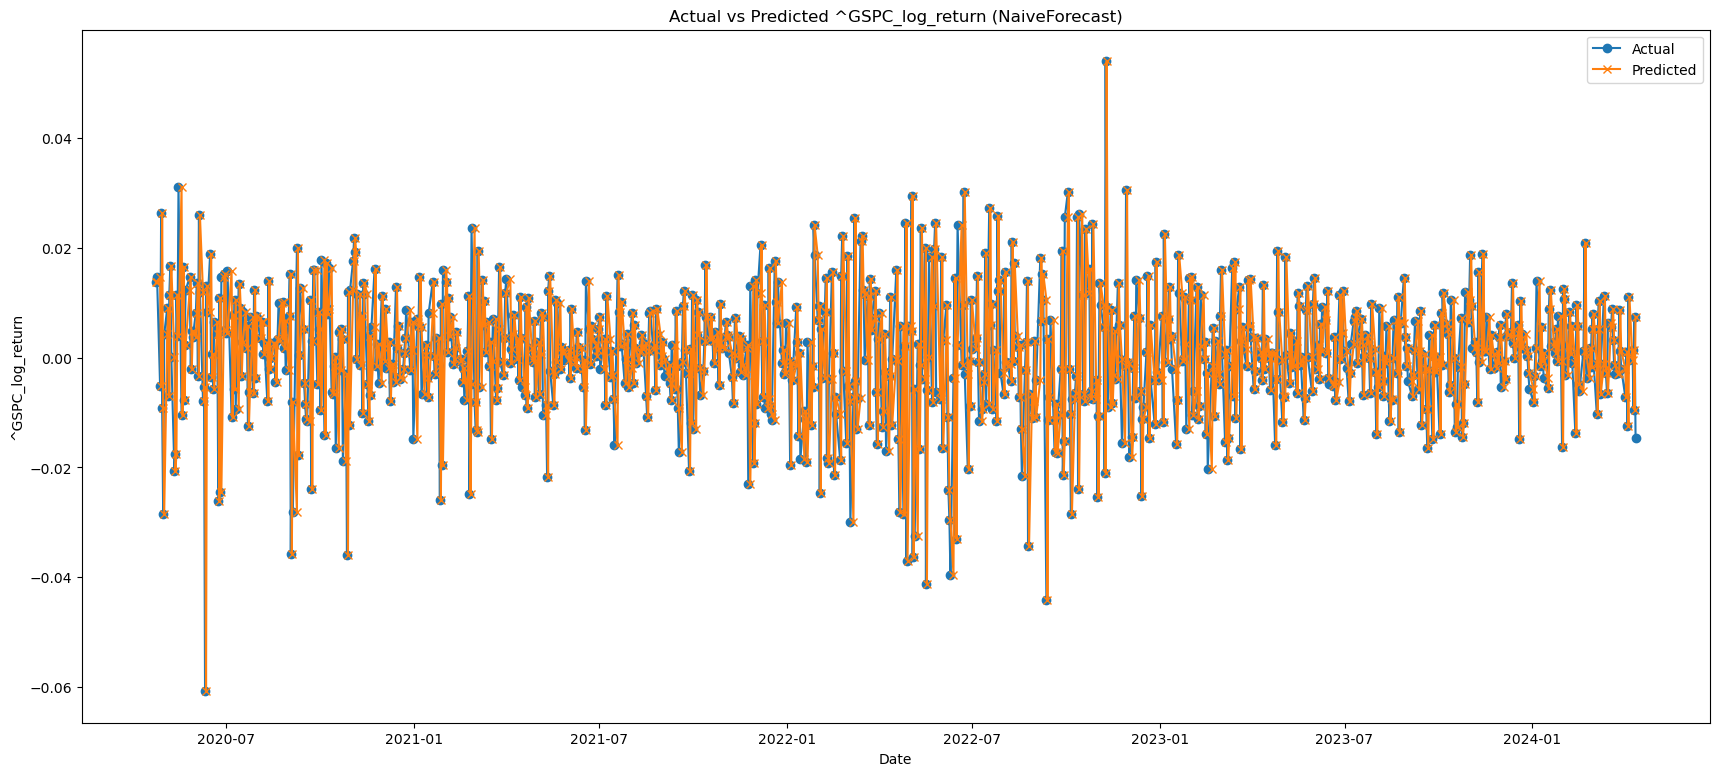

Model: LinearRegression
MAE: 0.0084
MSE: 0.0001
RMSE: 0.0112
direction: 0.5285


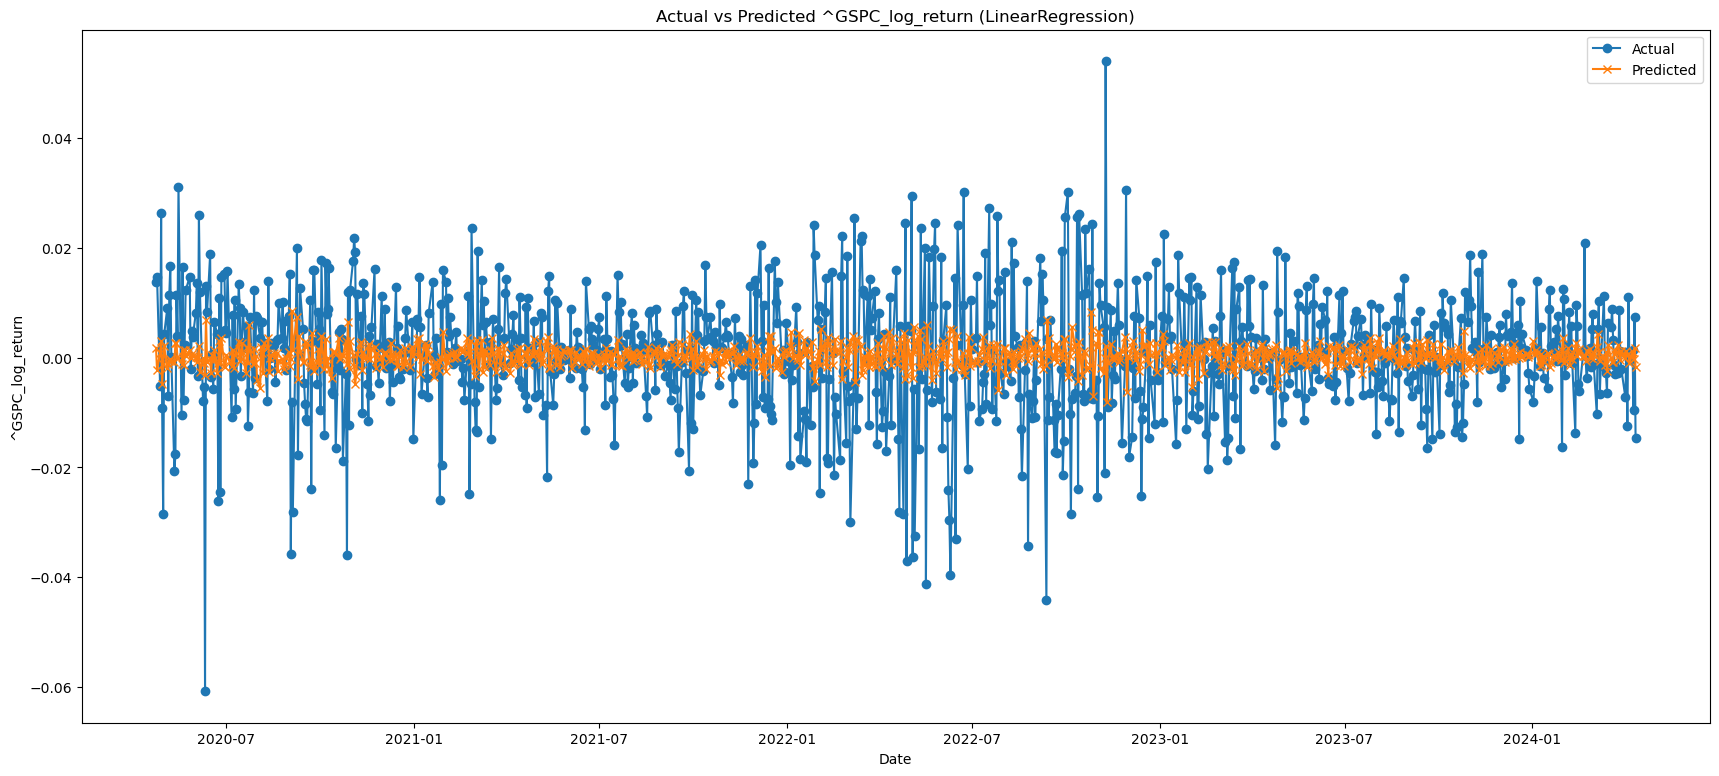

Model: SVR
MAE: 0.0169
MSE: 0.0004
RMSE: 0.0192
direction: 0.4675


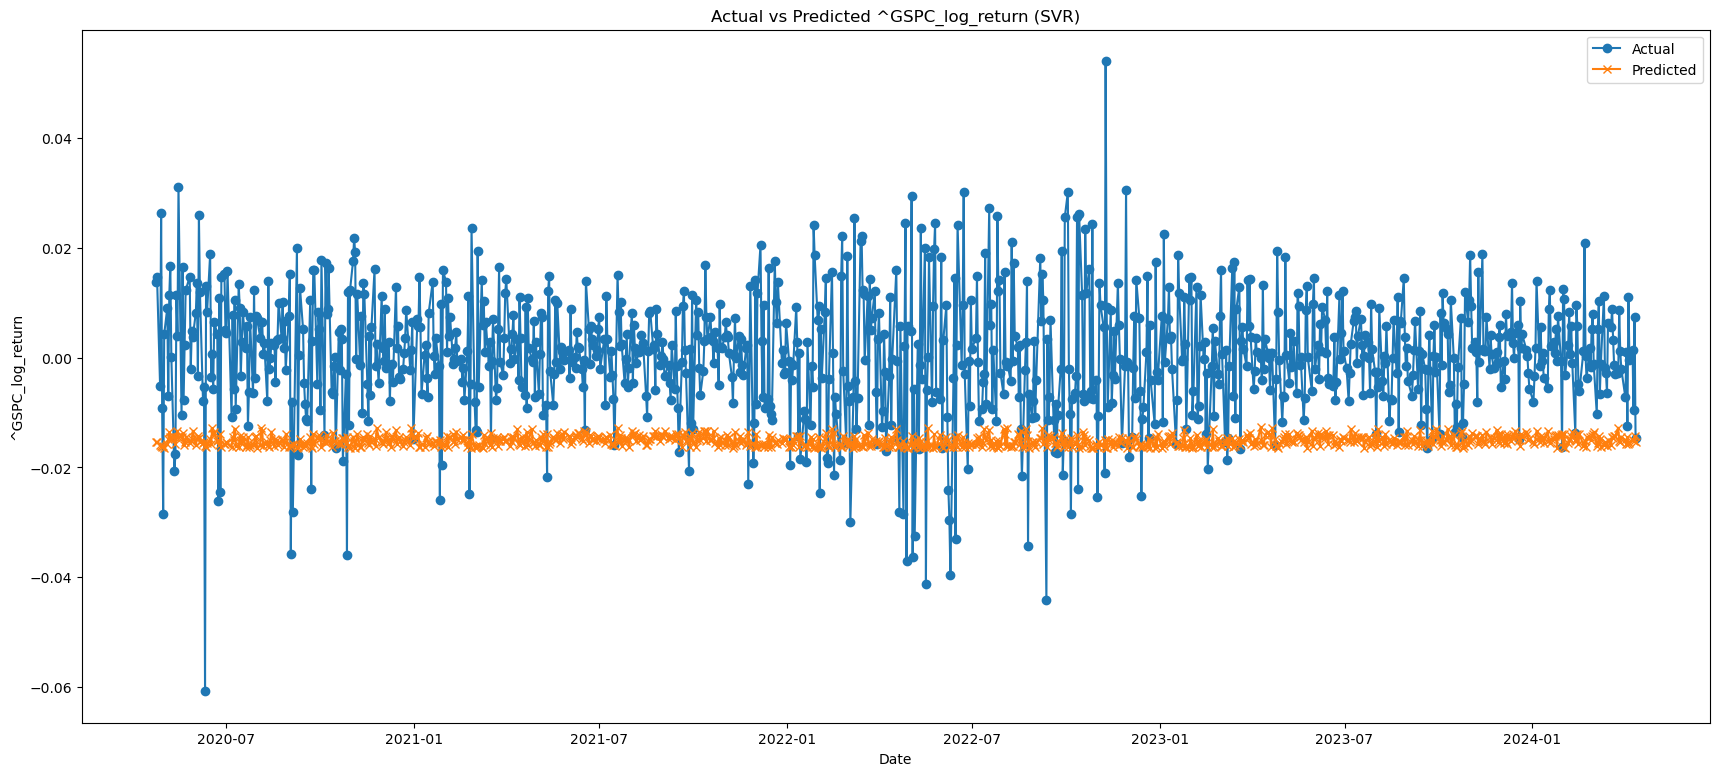

Model: RFR
MAE: 0.0088
MSE: 0.0001
RMSE: 0.0118
direction: 0.4975


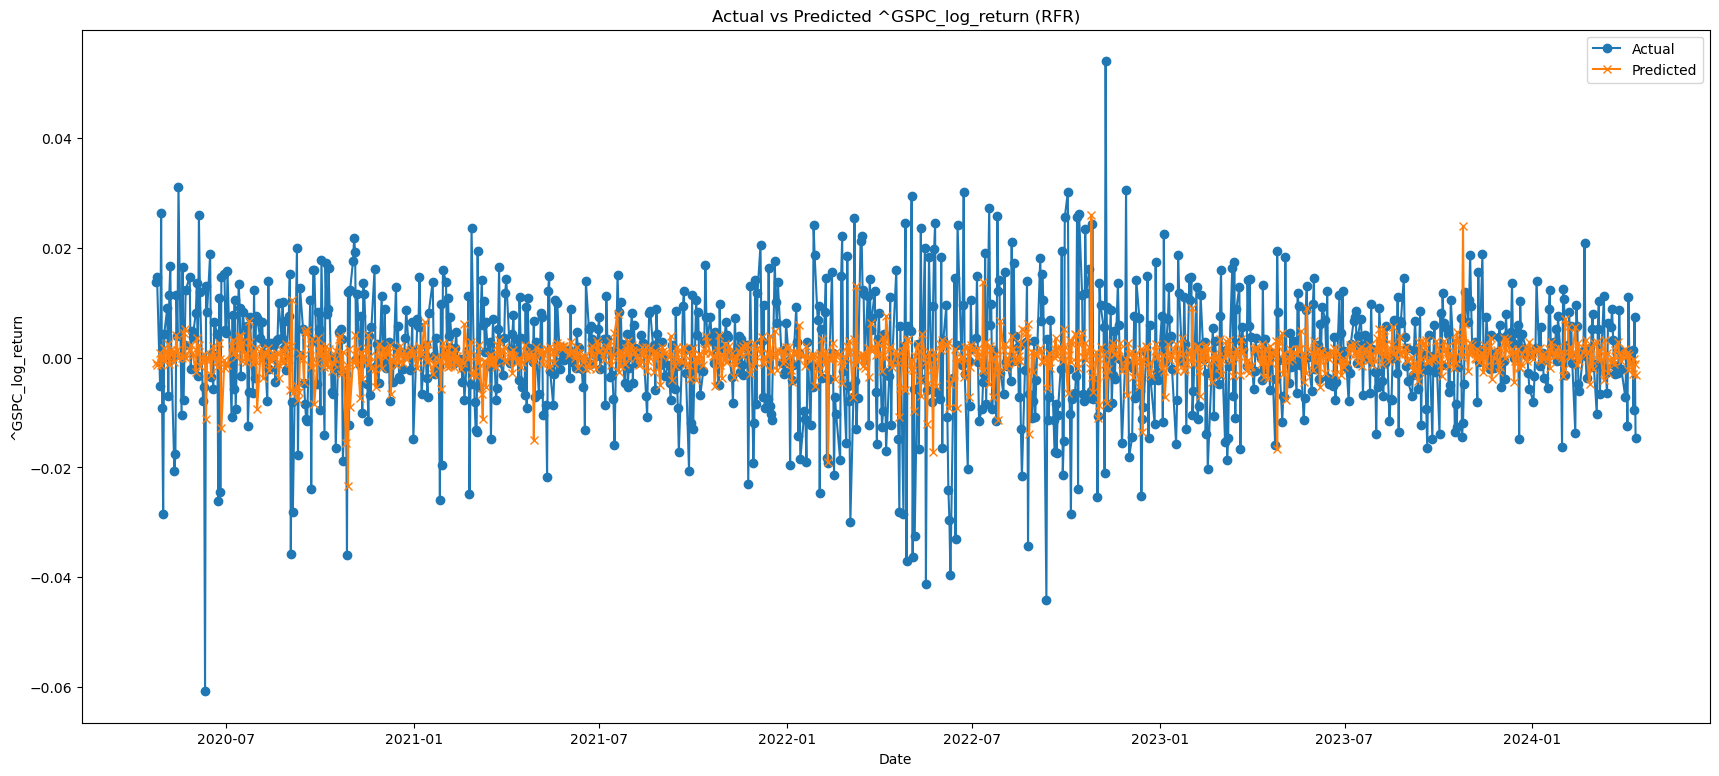

Model: LSTM
MAE: 0.0086
MSE: 0.0001
RMSE: 0.0114
direction: 0.4675


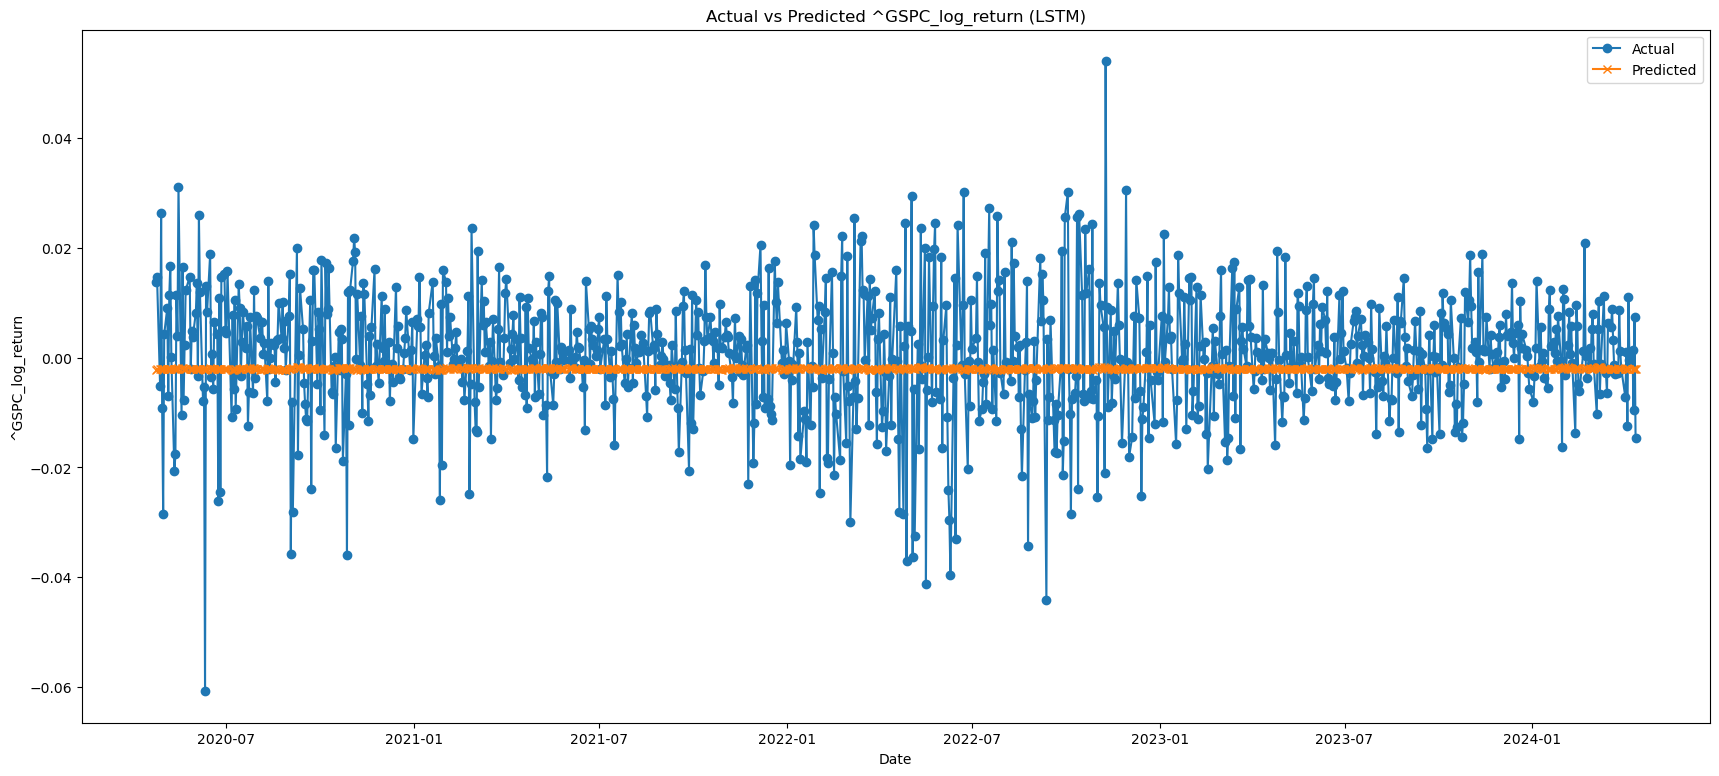

In [12]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"direction: {metrics['direction']:.4f}")
    
    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()

In [13]:
results

{'NaiveForecast': {'model': None,
  'y_pred_test': 2020-04-23    0.013822
  2020-04-24    0.013822
  2020-04-27    0.014607
  2020-04-28   -0.005256
  2020-04-29    0.026237
                  ...   
  2024-04-05    0.011038
  2024-04-08   -0.000375
  2024-04-09    0.001444
  2024-04-10   -0.009502
  2024-04-11    0.007417
  Name: ^GSPC_log_return, Length: 999, dtype: float64,
  'mae': 0.011841334065296093,
  'mse': 0.0002516576022765202,
  'rmse': 0.0158637196860169,
  'direction': 0.4824824824824825},
 'LinearRegression': {'model': LinearRegression(),
  'y_pred_test': array([ 1.77236350e-03, -2.32165320e-03,  9.14241530e-04,  3.00751268e-03,
         -4.81765368e-03, -1.25348277e-03,  2.01851019e-03, -1.91822718e-03,
         -1.13965385e-03, -5.56699302e-04, -3.04341435e-04, -6.42355800e-04,
         -8.05920809e-04,  2.55913597e-03,  2.58967015e-03,  1.75369043e-04,
         -1.65010130e-04, -1.08609167e-03,  1.44000069e-03, -1.30182630e-03,
          1.36081101e-03,  2.14857461e-04